In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
h0 = 2.27e-18
sol = 3e08

def muth(lumdist):
    return 5*log10(lumdist/3.09e17)  # dl in pc

def mu(lumdist, nhat, dipole):
    return muth(lumdist)*(1+dot(nhat, dipole))

import scipy.integrate as si

def dl(z, omegam):
    myint = si.quad(integrand, 0, z, args=(omegam))
    
    return 3e08*((1+z)/(h0))*myint[0]

def integrand(z, omegam):
    return 1/E(z, omegam)

def E(z, omegam):
    return sqrt(omegam*(1+z)**3 + (1-omegam))

In [3]:
from astropy.coordinates import ICRS, Galactic
from astropy import units as u

def convert_coords(ra, dec):
    """gives unit vector in direction of sne"""
    c = ICRS(ra, dec, unit=(u.deg, u.deg))
    l = c.galactic.l
    b = c.galactic.b
    return np.array([cos(b)*cos(l), cos(b)*sin(l), sin(b)])

In [4]:
import pandas

# Step 1: Get Data

with open("../data/jla_data_toconvert.txt", 'r') as jlaraw:
    jlarawstr = jlaraw.read()
    
jlarawlines = jlarawstr.split("\n")

i = 0
headings = []
while (jlarawlines[i] != r"#end"):
    thisline = jlarawlines[i]
    i+=1
    if thisline[0] == r"@":
        continue
    else:
        headings.append(thisline[1:-1])
        
#SNTYPE, SURVEY and name have str type but all others have float type
types = []

for heading in headings:  # this doesn't actually work bro
    if heading in ['SNTYPE', 'SURVEY', 'name', 'LCSRC_0']:
        types.append(np.str_)
    else:
        types.append(np.float_)

# now we actually need to parse data into an array. This is going to be very messy. Sorry, future me if this breaks.
fulllist = []

for line in jlarawlines:
    if line:
        if (line[0]=='#') or (line[0]=='@'):
            continue
        else:
            thisarry = np.empty_like(types)
            thislist = line.split("  ")
            for i in range(len(thisarry)):
                thisarry[i] = thislist[i]
        
            fulllist.append(thisarry)
            

fullarray = np.array(fulllist)

jla = pandas.DataFrame(data=fullarray, columns=headings)

# correct SDSS data

corrected = array(jla.loc[jla['SURVEY']=='SDSS']['RA'], dtype=float) + 180
jla.loc[jla['SURVEY']=='SDSS', 'RA'] = corrected

# now convert to different data types

for heading in headings:
    if heading in ['SNTYPE', 'SURVEY', 'name', 'LCSRC_0']:
        jla[heading] = jla[heading].astype(str)
    else:
        jla[heading] = jla[heading].astype(float)

In [5]:
zs = array(jla['z'])
mus = array(jla['msb']) + 19.2
mues = array(jla['msbe'])
ras = array(jla['RA'])
decs = array(jla['DEC'])

In [6]:
def myfit(z, omegam):
    lumdist = dl(z, omegam)
    return muth(lumdist)

vmyfit = vectorize(myfit)

from scipy.optimize import curve_fit

curve_fit(vmyfit, zs, mus, [0.3], mues, absolute_sigma=True)

(array([ 0.28886287]), array([[  3.84759564e-05]]))

In [7]:
#(vmyfit(zs, 0.3) - mus)/mus

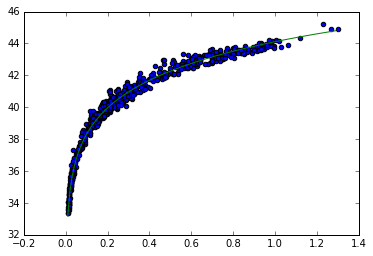

In [8]:
plotz = np.arange(0, 1.3, 0.01)
plot(plotz, vmyfit(plotz, 0.2888), color='g')
scatter(zs, mus)

In [9]:
omegam = 0.2889

import lmfit

params = lmfit.Parameters()

params.add('x', value=0., vary=True)
params.add('y', value=0., vary=True)
params.add('z', value=0., vary=True)

#input variable is going to be index
xs = arange(0, 740)

In [10]:
def chisq(zs, ras, decs, mus, mues, x, y, z):
    muths = empty_like(zs)
    for index in range(len(zs)):
        myz = zs[index]
        ra = ras[index]
        dec = decs[index]
        thismu = mus[index]
        mue = mues[index]
        lumdist = dl(myz, omegam)
        nhat = convert_coords(ra, dec)

        dipole = array([x, y, z])
        muths[i] = mu(lumdist, nhat, dipole)

    return ((mus - muths)/mues)**2

In [11]:
def tofit(params, zs=zs, ras=ras, decs=decs, mus=mus, mues=mues):
    return chisq(zs, ras, decs, mus, mues, params['x'].value, params['y'].value, params['z'].value)

In [12]:
out = lmfit.minimize(tofit, params, args=(zs, ras, decs, mus, mues), method='leastsq')

print(lmfit.fit_report(out))

[[Fit Statistics]]
    # function evals   = 6
    # data points      = 740
    # variables        = 3
    chi-square         = nan
    reduced chi-square = nan
[[Variables]]
    x:   0          +/- 0        (nan%) (init= 0)
    y:   0          +/- 0        (nan%) (init= 0)
    z:   1.4901e-08 +/- 0        (0.00%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)


In [12]:
vd = vectorize(dl)

lumdists = vd(zs, omegam)

In [13]:
muths = muth(lumdists)

In [38]:
dmu = mus - muths
radra, raddec = (ras-180)*(pi/180), decs*(pi/180)

In [16]:
from scipy.interpolate import interp2d

myinterp = interp2d(radra, raddec, dmu)
xnew = np.arange(-pi, pi, 0.001)
ynew = np.arange(-pi/2, pi/2, 0.001)

myinterpmu = myinterp(xnew, ynew)


/home/josh/josh.borrow@gmail.com/supernova-cosmology/env/lib/python3.4/site-packages/scipy/interpolate/fitpack.py:975: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=31,28 m=740 fp=25.100079 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


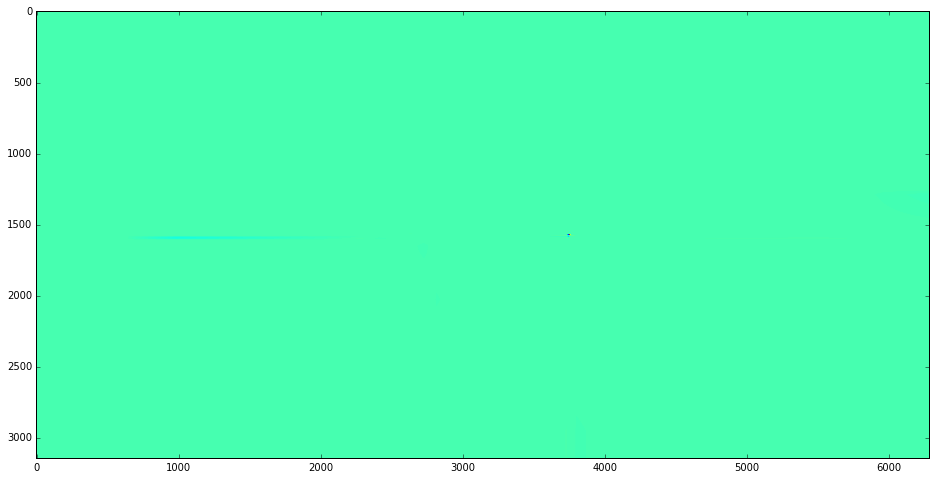

In [17]:
fig = pylab.figure(figsize=(16,12))
ax = fig.add_subplot(111)

im = ax.imshow(myinterpmu)

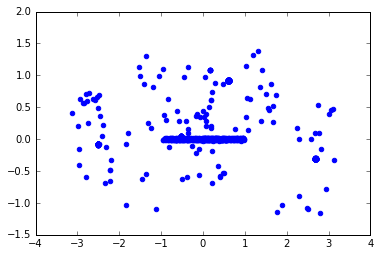

In [18]:
scatter(radra, raddec, color='b')

(array([   2.,   26.,  139.,  223.,  182.,   99.,   44.,   18.,    6.,    1.]),
 array([-0.79967007, -0.59217045, -0.38467082, -0.1771712 ,  0.03032843,
         0.23782805,  0.44532767,  0.6528273 ,  0.86032692,  1.06782655,
         1.27532617]),
 <a list of 10 Patch objects>)

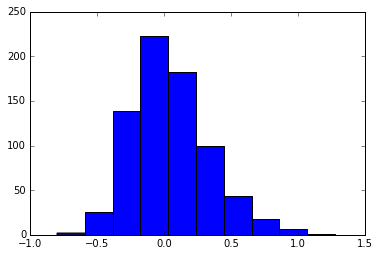

In [19]:
hist(dmu)

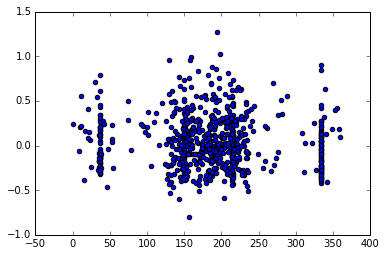

In [20]:
scatter(ras, dmu)

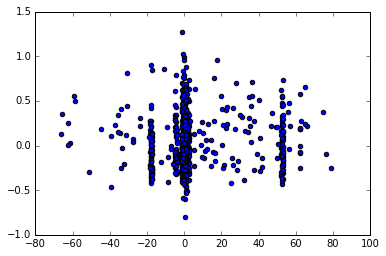

In [21]:
scatter(decs, dmu)

In [22]:
import scipy

interp = scipy.interpolate.Rbf(radra, raddec, dmu, function='thin_plate')

In [23]:
XX, YY = numpy.mgrid[-pi/2:pi/2:0.01, -pi:pi:0.01]
zi = interp(XX, YY)

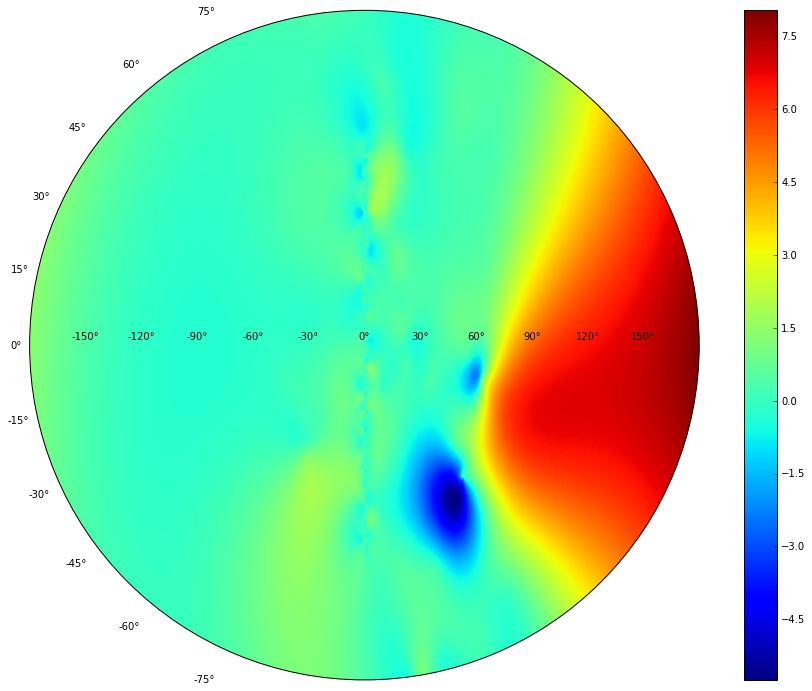

In [24]:
fig = pylab.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='mollweide')

img = ax.imshow(zi, extent=[-pi,pi,-pi/2,pi/2])

fig.colorbar(img)

TypeError: __init__() got an unexpected keyword argument 'position'

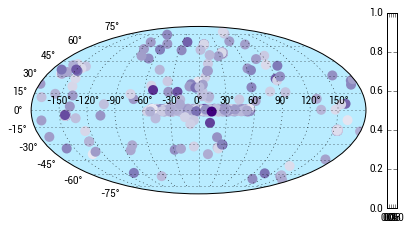

In [108]:
fig = pylab.figure(figsize=(7.5,3.5))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid(True)

ax.set_axis_bgcolor('#B9ECFF')

mymap = plt.get_cmap("Purples")
# get the colors from the color map
#my_colors = mymap(dmu)
# here you give floats as color to scatter and a color map
# scatter "translates" this
thisscatter = ax.scatter(radra, raddec, s=100,
                c=dmu, edgecolors='None',
                cmap=mymap)

fig.colorbar(thisscatter, label="$\Delta\mu$")
xlabel('RA ($^\circ$)')
ylabel('Dec ($^\circ$)')

plt.savefig('../results/allsky.svg')

In [26]:
from scipy import interpolate
x = np.arange(-pi, pi, 0.001)
y = np.arange(-pi/2, pi/2, 0.001)
XX, YY = np.meshgrid(x, y)

f = interpolate.griddata((radra, raddec), dmu, (XX, YY), method='nearest', fill_value=0)


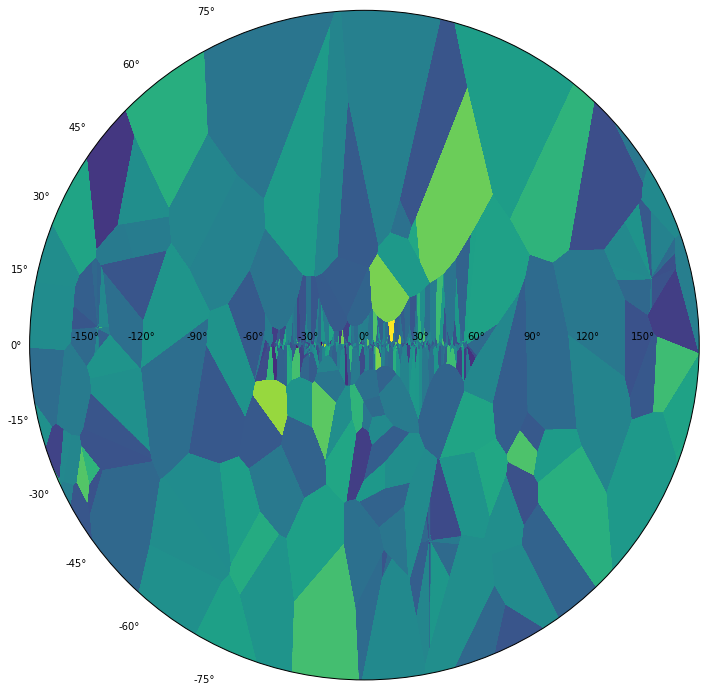

In [27]:
fig = pylab.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='mollweide')

ax.imshow(f, extent=[-pi,pi,-pi/2,pi/2]).set_cmap('viridis')

In [28]:
from scipy import ndimage

f2 = ndimage.filters.gaussian_filter(f, 75, mode='nearest')

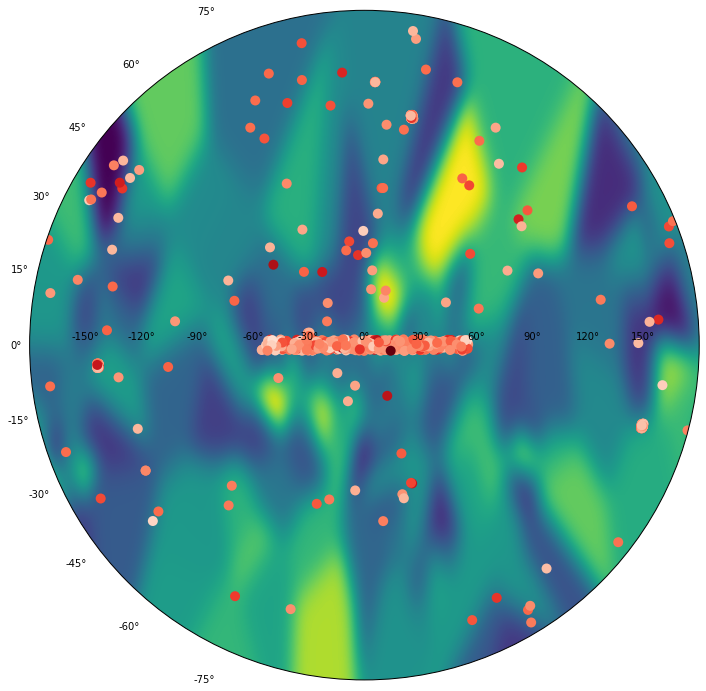

In [29]:
fig = pylab.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection='mollweide')

ax.imshow(f2, extent=[-pi,pi,-pi/2,pi/2]).set_cmap('viridis')

mymap = plt.get_cmap("Reds")
# get the colors from the color map
my_colors = mymap(dmu)
# here you give floats as color to scatter and a color map
# scatter "translates" this
thisscatter = ax.scatter(radra, raddec, s=100,
                c=dmu, edgecolors='None',
                cmap=mymap)

In [30]:
jla['dmu'] = dmu

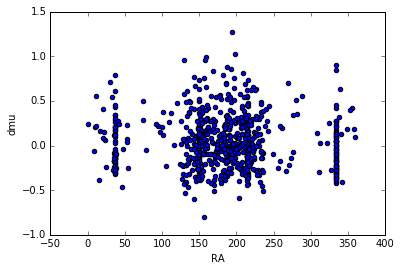

In [31]:
jla.plot(x='RA', y='dmu', kind='scatter')

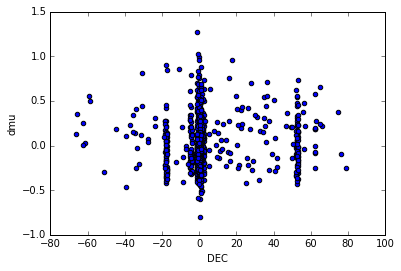

In [32]:
jla.plot(x='DEC', y='dmu', kind='scatter')

In [39]:
my2d = empty((180, 360))

In [40]:
from scipy.stats.stats import pearsonr

In [46]:
decsorted, dmudecs = (list (t) for t in zip(*sorted(zip(list(decs+90), list(dmu)))))
rasorted, dmuras = (list (t) for t in zip(*sorted(zip(list(ras), list(dmu)))))


def movelist(mylist, index):
    newTop = mylist[:-index]
    newBottom = mylist[-index:]
    return newBottom + newTop

for dec in range(0, 180):
    newDec = movelist(decsorted, dec)
    newDmuDec = movelist(dmudecs, dec)
    
    thisdecr = pearsonr(decs, newDmuDec)
    for rad in range(0, 360):
        newRad = movelist(rasorted, rad)
        newDmuRad = movelist(dmuras, rad)
        thisrar = pearsonr(ras[:180], newDmuRad[:180])
        
        my2d[dec, rad] = (abs(thisdecr[0])+ abs(thisrar[0]))/2


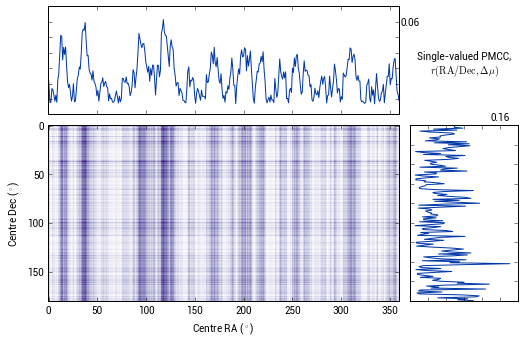

In [101]:
matplotlib.rc('font', family='Roboto') 
matplotlib.rc('font', serif='Roboto') 

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65/2
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h-height, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
disfig = plt.figure(1, figsize=(7.5, 7.5))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)


Thisimg = axScatter.imshow(my2d, interpolation='nearest').set_cmap("Purples")

axHistx.plot(range(360), my2d.sum(axis=0)/360, color="#0038A8")
axHisty.plot(my2d.sum(axis=1)/180, range(180),  color="#0038A8")

nullfmt = NullFormatter()

axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(nullfmt)
axHisty.xaxis.set_major_formatter(nullfmt)

axHistx.set_xlim((0, 359))

axScatter.set_xlabel("Centre RA ($^\circ$)")
axScatter.set_ylabel("Centre Dec ($^\circ$)")

text(0.15,185, r'0.16')
text(0.05,283, r'0.06')

text(0.12,230, 'Single-valued PMCC,\n $r(\mathrm{RA}/\mathrm{Dec}, \Delta\mu )$', ha='center')


plt.savefig('../results/pmcc.svg', dpi=2400)

In [ ]:
plot(range(360), my2d.sum(axis=0))
plot(range(180), my2d.sum(axis=1))

(array([38]), array([118]))
(0.10526048306062148, 0.004150106987441571)
0.074541740698


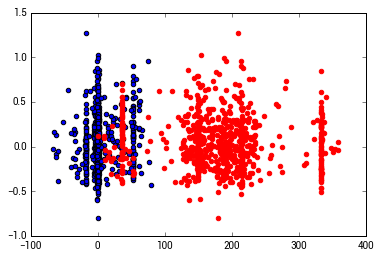

In [50]:
print(np.where(my2d == my2d.max()))
scatter(decs, movelist(dmudecs, 38))
scatter(ras, movelist(dmuras, 118), color='r')
print(pearsonr(decs, movelist(dmudecs, 38)))

print((pearsonr(decs, movelist(dmudecs, 39))[1]-pearsonr(decs, movelist(dmudecs, 37))[1])/2)

In [ ]:
scatter( array(movelist(decsorted, 27)), movelist(dmudecs, 27))

In [ ]:
sqrt(((dmu/mues)**2).mean())

In [93]:
from jla_data_fix import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


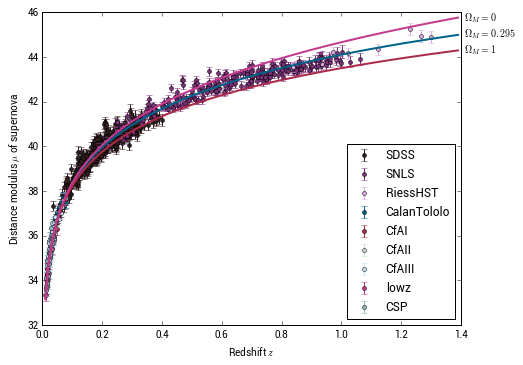

In [94]:
figure(figsize=(7.5, 5.6))

matplotlib.rc('font', family='Roboto') 
matplotlib.rc('font', serif='Roboto') 

for i in range(len(surveys)):
    survey = surveys[i]
    color = ducolors[i]
    thisz = zs[i]
    thismsb = msbs[i]
    thismsbe = msbes[i]
    
    errorbar(thisz,
             thismsb + 19.2,
             yerr=thismsbe*2,
             color=color,
             fmt='o',
             ms=4,
             label=survey) 

legend(loc=4, numpoints=1)

plotz = np.arange(0, 1.4, 0.01)
plot(plotz, vmyfit(plotz, 0.295), color=ducolors[3], lw=2)
plot(plotz, vmyfit(plotz, 1), color=ducolors[4], lw=2)
plot(plotz, vmyfit(plotz, 0), color=ducolors[7], lw=2)

ylabel("Distance modulus $\mu$ of supernova")
xlabel("Redshift $z$")

text(1.41, 45.6, r'$\Omega_M = 0$')
text(1.41, 44.9, r'$\Omega_M = 0.295$')
text(1.41, 44.2, r'$\Omega_M = 1$')

plt.savefig("../results/muz.svg")

In [45]:
my2d

array([[  7.64323212e-002,   5.52569145e-002,   3.38858047e-002, ...,
          4.88705687e-002,   4.48719846e-002,   1.94332793e-051],
       [  6.76244304e-002,   4.64490238e-002,   2.50779139e-002, ...,
          4.00626780e-002,   3.60640938e-002,   4.78204591e+262],
       [  7.32451979e-002,   5.20697912e-002,   3.06986814e-002, ...,
          4.56834454e-002,   4.16848613e-002,   6.15006876e+276],
       ..., 
       [  7.06112241e-002,   4.94358174e-002,   2.80647076e-002, ...,
          4.30494716e-002,   3.90508875e-002,  -1.27282364e+306],
       [  6.56737208e-002,   4.44983142e-002,   2.31272043e-002, ...,
          3.81119684e-002,   3.41133842e-002,  -1.27282364e+306],
       [  6.60018465e-002,   4.48264399e-002,   2.34553301e-002, ...,
          3.84400941e-002,   3.44415099e-002,               nan]])

In [47]:
from pyanis import arrayofanis

output = arrayofanis(radra+pi, raddec, dmu)

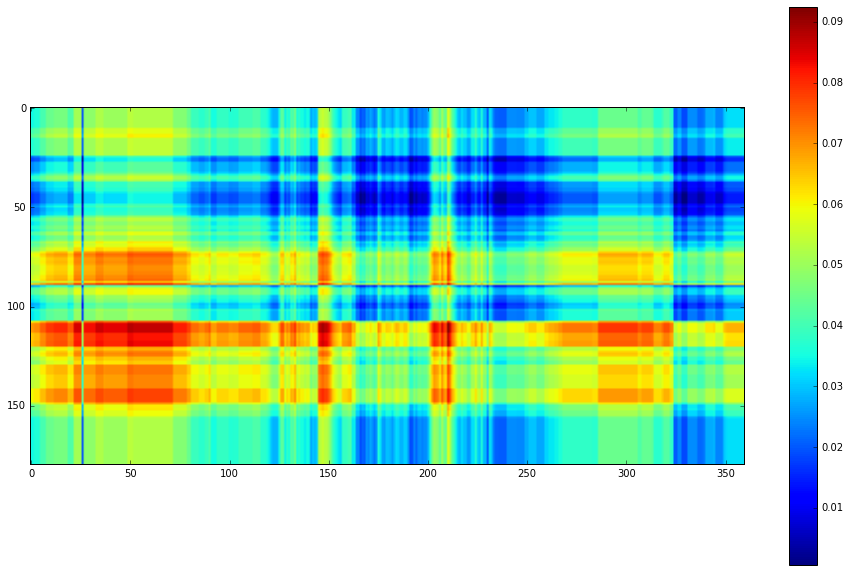

In [48]:
figure(figsize=(16,10))
imshow(output.T)
colorbar()

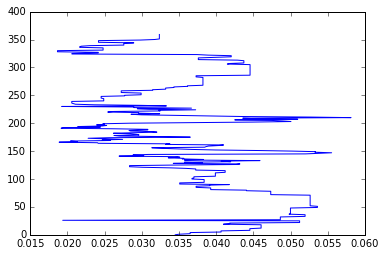

In [49]:
plot(output[:,0], range(360))

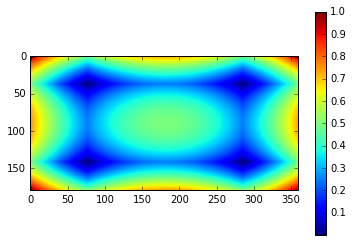

In [31]:
    inputra = arange(0, 2*pi, 0.01)
    inputdec = arange(-0.5*pi, 0.5*pi, 0.005)
    dmu = inputra
    output = arrayofanis(inputra, inputdec, dmu).T
    
    imshow(output)
    colorbar()



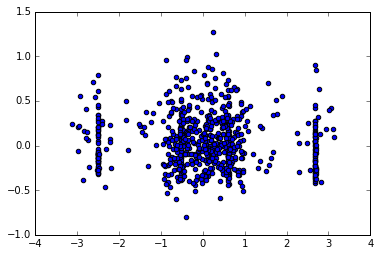

In [46]:
scatter(radra, dmu)